In [1]:
# Import the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from kneed import KneeLocator
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
%config InlineBackend.figure_format ='retina'
import plotly.graph_objects as go
from plotly.subplots import make_subplots

## 1. Data Cleaning - Processing
### Read in the dataset

In [2]:
# Read in the data
df_init = pd.read_csv('whiskey_data.csv')
display(df_init.shape)
df_init.head()

(2636, 7)

,Unnamed: 0,name,category,rating,price,currency,description
0,0,"Black Bowmore 42 year old 1964 vintage, 40.5%",Single Malt Scotch,97,4500,$,What impresses me most is how this whisky evol...
1,1,"Bowmore 46 year old (distilled 1964), 42.9%",Single Malt Scotch,97,13500,$,There have been some legendary Bowmores from t...
2,2,"Johnnie Walker Blue Label, 40%",Blended Scotch Whisky,97,225,$,"Magnificently powerful and intense. Caramels, ..."
3,3,"Glenlivet Cellar Collection 1969 vintage, 50.8%",Single Malt Scotch,96,750,$,It’s great that Glenlivet releases whiskies un...
4,4,The Macallan 29 year old 1976 Vintage (Cask #1...,Single Malt Scotch,96,"1,500",$,Classic sherry cask-aged Macallan. Antique amb...


### Check for nulls / Drop redundant columns

In [3]:
df_init.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2636 entries, 0 to 2635
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   2636 non-null   int64 
 1   name         2636 non-null   object
 2   category     2636 non-null   object
 3   rating       2636 non-null   int64 
 4   price        2636 non-null   object
 5   currency     2636 non-null   object
 6   description  2636 non-null   object
dtypes: int64(2), object(5)
memory usage: 144.3+ KB


No nulls at all!

In [4]:
# Brief check for columns with the least unique values
for col in df_init.columns:
    if len(df_init[col].unique()) < 3:
            display(df_init[col].unique()) 

array(['$'], dtype=object)

The `currency` column is fixed to '$', hence we drop it.

In [5]:
df_init.drop(columns=['Unnamed: 0', 'currency'], inplace=True)

### Convert types

We evaluate the `price` column for potential alphabetical characters.

In [6]:
# Find all the rows that the price col contains alphabetical characters
pattern = r'[A-Za-z]'
df_init[df_init['price'].str.contains(pattern)]['price']

33      15,000 or $60,000/set
92                 150/375ml.
94                  50/375ml.
186                60,000/set
359                 50/375ml.
739                60,000/set
778                100/375ml.
1010                 44/liter
1280               132/700ml.
1548               60,000/set
1814               60,000/set
1825            39/1.75 liter
2027                 35/liter
2200            18/1.75 liter
Name: price, dtype: object

Apart from the the first one which goes for 15.000 dollars (the unit price), the rest are obvious. We are going to treat them uniformly, using a lambda function.

In [7]:
# Replace the 33rd row with the 15.000 dollars unit price
df_init.iloc[33,3] = '15000'

# Remove ','
df_init['price'].replace(',', '', inplace = True, regex = True)

# Split on the '/' character and keep the 1st element
df_init['price'] = df_init['price'].map(lambda x: x.split('/')[0])

In [8]:
# Check for valid results
df_init[df_init['price'].str.contains(pattern)]['price']

Series([], Name: price, dtype: object)

In [9]:
# Convert to float type
df_init['price'] = df_init['price'].astype('float')
df_init.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2636 entries, 0 to 2635
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         2636 non-null   object 
 1   category     2636 non-null   object 
 2   rating       2636 non-null   int64  
 3   price        2636 non-null   float64
 4   description  2636 non-null   object 
dtypes: float64(1), int64(1), object(3)
memory usage: 103.1+ KB


### Check for duplicates

In [10]:
# Check for duplicated liquors
df_init.duplicated('name').sum()

70

In [11]:
#pd.set_option('display.max_rows', None)
df_init[df_init.duplicated(subset=['name'], keep=False)].sort_values('name')

,name,category,rating,price,description
232,Aberfeldy 18 year old French Red Wine Cask-Fin...,Single Malt Scotch,93,120.0,\r\n\r\nAging scotch in a secondary cask is tr...
227,Aberfeldy 18 year old French Red Wine Cask-Fin...,Single Malt Scotch,93,120.0,"\nCreamy on the nose, with malt, toasted cerea..."
217,Aberlour A’bunadh Alba Cask Strength (Batch #0...,Single Malt Scotch,93,90.0,"Sweet and clean, with aromas of honeysuckle, c..."
211,Aberlour A’bunadh Alba Cask Strength (Batch #0...,Single Malt Scotch,93,90.0,"The yin to Aberlour A’bunadh’s yang, this cask..."
109,"Ardbeg 5 year old Wee Beastie, 47.4%",Single Malt Scotch,94,47.0,\r\n\r\nThe youthful age statement may take ma...
...,...,...,...,...,...
1635,"Tomintoul 16 year old, 40%",Single Malt Scotch,86,40.0,"The ""Gentle Dram,"" it says on the bottle’s lab..."
809,"Tomintoul 25 year old, 43%",Single Malt Scotch,90,500.0,A 2015 addition to the Tomintoul range of sing...
708,"Tomintoul 25 year old, 43%",Single Malt Scotch,90,415.0,This is the oldest core expression of Tomintou...
1920,Wemyss Malts (distilled at Clynelish) “A Day a...,Single Malt Scotch,85,95.0,One of the latest batch of single cask bottlin...


In [12]:
# For each duplicate group, calculate the mean and set it on a new column
df_init['m_rating'] = df_init.groupby('name')['rating'].transform('mean')
df_init['m_price'] = df_init.groupby('name')['price'].transform('mean')

In [13]:
# Check the results
df_init[df_init.duplicated(subset=['name'], keep=False)].sort_values('name')

,name,category,rating,price,description,m_rating,m_price
232,Aberfeldy 18 year old French Red Wine Cask-Fin...,Single Malt Scotch,93,120.0,\r\n\r\nAging scotch in a secondary cask is tr...,93.0,120.0
227,Aberfeldy 18 year old French Red Wine Cask-Fin...,Single Malt Scotch,93,120.0,"\nCreamy on the nose, with malt, toasted cerea...",93.0,120.0
217,Aberlour A’bunadh Alba Cask Strength (Batch #0...,Single Malt Scotch,93,90.0,"Sweet and clean, with aromas of honeysuckle, c...",93.0,90.0
211,Aberlour A’bunadh Alba Cask Strength (Batch #0...,Single Malt Scotch,93,90.0,"The yin to Aberlour A’bunadh’s yang, this cask...",93.0,90.0
109,"Ardbeg 5 year old Wee Beastie, 47.4%",Single Malt Scotch,94,47.0,\r\n\r\nThe youthful age statement may take ma...,93.0,47.0
...,...,...,...,...,...,...,...
1635,"Tomintoul 16 year old, 40%",Single Malt Scotch,86,40.0,"The ""Gentle Dram,"" it says on the bottle’s lab...",87.0,56.0
809,"Tomintoul 25 year old, 43%",Single Malt Scotch,90,500.0,A 2015 addition to the Tomintoul range of sing...,90.0,457.5
708,"Tomintoul 25 year old, 43%",Single Malt Scotch,90,415.0,This is the oldest core expression of Tomintou...,90.0,457.5
1920,Wemyss Malts (distilled at Clynelish) “A Day a...,Single Malt Scotch,85,95.0,One of the latest batch of single cask bottlin...,85.0,100.0


In [14]:
# Drop the duplicate columns (keep the first each time)
df_init.drop_duplicates(subset=['name'], keep='first', inplace=True)

# Drop the old columns
df_init.drop(columns=['price', 'rating'], inplace=True)
df_init.shape

(2566, 5)

In [15]:
# Rename the affected columns
df_init.rename(columns={"m_rating": "rating", "m_price": "price"}, inplace=True)
df_init = df_init[['name', 'category', 'rating', 'price', 'description']]
df_init.head()

,name,category,rating,price,description
0,"Black Bowmore 42 year old 1964 vintage, 40.5%",Single Malt Scotch,97.0,4500.0,What impresses me most is how this whisky evol...
1,"Bowmore 46 year old (distilled 1964), 42.9%",Single Malt Scotch,97.0,13500.0,There have been some legendary Bowmores from t...
2,"Johnnie Walker Blue Label, 40%",Blended Scotch Whisky,97.0,225.0,"Magnificently powerful and intense. Caramels, ..."
3,"Glenlivet Cellar Collection 1969 vintage, 50.8%",Single Malt Scotch,96.0,750.0,It’s great that Glenlivet releases whiskies un...
4,The Macallan 29 year old 1976 Vintage (Cask #1...,Single Malt Scotch,96.0,1500.0,Classic sherry cask-aged Macallan. Antique amb...


### Extract new features

In [16]:
df_init.shape

(2566, 5)

In [17]:
df_init[df_init['name'].str.contains('%')].count()

name           2554
category       2554
rating         2554
price          2554
description    2554
dtype: int64

Since only 12 rows do not contain alcohol ABV, it worths extracting that info.

In [18]:
# Switch to the final df
df = df_init.copy()

In [19]:
df['name'] = df['name'].str.replace(' ABV ', '')
df['alcohol'] = df['name'].str.extract(r"([\(\,\,\'\"\’\”\$] ? ?\d+(\.\d+)?%)")[0]
df['alcohol'] = df['alcohol'].str.replace("[^\d\.]", "").astype(float)

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2566 entries, 0 to 2635
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         2566 non-null   object 
 1   category     2566 non-null   object 
 2   rating       2566 non-null   float64
 3   price        2566 non-null   float64
 4   description  2566 non-null   object 
 5   alcohol      2553 non-null   float64
dtypes: float64(3), object(3)
memory usage: 140.3+ KB


In [21]:
df['alcohol'].unique()

array([40.5 , 42.9 , 40.  , 50.8 , 45.4 , 52.8 , 42.4 , 44.8 , 53.4 ,
       47.2 , 60.  , 49.9 , 43.  , 54.4 , 50.5 , 55.7 , 52.  , 45.7 ,
       51.2 , 50.  , 46.  , 53.2 , 49.  , 48.9 , 44.6 , 54.3 , 40.7 ,
       54.7 , 50.9 , 46.6 , 57.1 , 42.5 , 46.2 , 51.9 , 41.  , 44.9 ,
       45.  , 53.  , 48.5 , 41.3 , 48.1 , 42.8 , 48.  , 42.2 , 45.9 ,
       45.8 , 56.5 , 58.1 , 50.3 , 45.6 , 55.8 , 59.1 , 48.6 , 51.3 ,
       47.6 , 52.5 , 57.3 , 41.5 , 54.2 , 43.8 , 58.6 , 50.2 , 52.7 ,
       55.2 , 43.7 , 60.4 , 47.4 ,   nan, 46.9 , 51.8 , 52.9 , 42.  ,
       46.5 , 44.7 , 59.8 , 60.7 , 45.1 , 47.5 , 48.3 , 57.7 , 46.7 ,
       54.6 , 56.7 , 57.9 , 55.4 , 61.6 , 54.9 , 43.4 , 48.8 , 56.6 ,
       50.4 , 43.5 , 51.  , 41.7 , 48.7 , 52.1 , 60.2 , 58.  , 50.1 ,
       58.5 , 47.8 , 60.6 , 56.1 , 53.3 , 51.4 , 62.4 , 56.4 , 63.5 ,
       54.1 , 49.4 , 51.5 , 41.1 , 46.1 , 54.8 , 40.2 , 55.  , 54.  ,
       55.6 , 52.3 , 44.  , 50.6 , 47.3 , 46.8 , 57.6 , 53.9 , 42.3 ,
       56.  , 53.6 ,

In [22]:
df['age'] = df['name'].str.extract(r'(\d+) year')[0].astype(float)

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2566 entries, 0 to 2635
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         2566 non-null   object 
 1   category     2566 non-null   object 
 2   rating       2566 non-null   float64
 3   price        2566 non-null   float64
 4   description  2566 non-null   object 
 5   alcohol      2553 non-null   float64
 6   age          1362 non-null   float64
dtypes: float64(4), object(3)
memory usage: 160.4+ KB


It seems like half the listings can be labeled with the age.

In [24]:
df = df[['name', 'category', 'rating', 'alcohol', 'age', 'price', 'description']]
df.head()

,name,category,rating,alcohol,age,price,description
0,"Black Bowmore 42 year old 1964 vintage, 40.5%",Single Malt Scotch,97.0,40.5,42.0,4500.0,What impresses me most is how this whisky evol...
1,"Bowmore 46 year old (distilled 1964), 42.9%",Single Malt Scotch,97.0,42.9,46.0,13500.0,There have been some legendary Bowmores from t...
2,"Johnnie Walker Blue Label, 40%",Blended Scotch Whisky,97.0,40.0,NaN,225.0,"Magnificently powerful and intense. Caramels, ..."
3,"Glenlivet Cellar Collection 1969 vintage, 50.8%",Single Malt Scotch,96.0,50.8,NaN,750.0,It’s great that Glenlivet releases whiskies un...
4,The Macallan 29 year old 1976 Vintage (Cask #1...,Single Malt Scotch,96.0,45.4,29.0,1500.0,Classic sherry cask-aged Macallan. Antique amb...


In [25]:
df.shape

(2566, 7)

## 2. EDA

## I. Apparent Insights

In [26]:
#Subset the numerical only columns
df_num = df.iloc[:,2:6]
df_num.describe()

,rating,alcohol,age,price
count,2566.000000,2553.000000,1362.000000,2566.000000
mean,87.303423,47.717524,20.029369,725.383898
std,3.916393,5.891493,9.609221,4718.304973
min,70.000000,40.000000,3.000000,10.000000
25%,85.000000,43.000000,12.000000,65.000000
50%,88.000000,46.000000,18.000000,108.000000
75%,90.000000,51.900000,25.000000,205.750000
max,97.000000,67.400000,70.000000,157000.000000


In [27]:
# Visualizing scatter plots

def visualize_box_plot(df, title):
    """
    Takes in a dataframe and the title of the plot.
    It returns a Whiskers Box Plot.
    Parameters
    ---------
    df           : a dataframe object
             Represents the dataframe to be depicted 
    title        : a string
             Passes the title of the plot
    Returns
    -------
    plot : plot
            A Box plot
    """
    with plt.style.context('fivethirtyeight'):
        df.boxplot(vert = False, figsize = (13,6), showfliers = False, showmeans = True, 
                 patch_artist=True, boxprops=dict(linestyle='-', linewidth=1.5),
                 flierprops=dict(linestyle='-', linewidth=1.5),
                 medianprops=dict(linestyle='-', linewidth=1.5),
                 whiskerprops=dict(linestyle='-', linewidth=1.5),
                 capprops=dict(linestyle='-', linewidth=1.5))
        plt.title(title, fontsize=16, fontweight='heavy')
        plt.show()

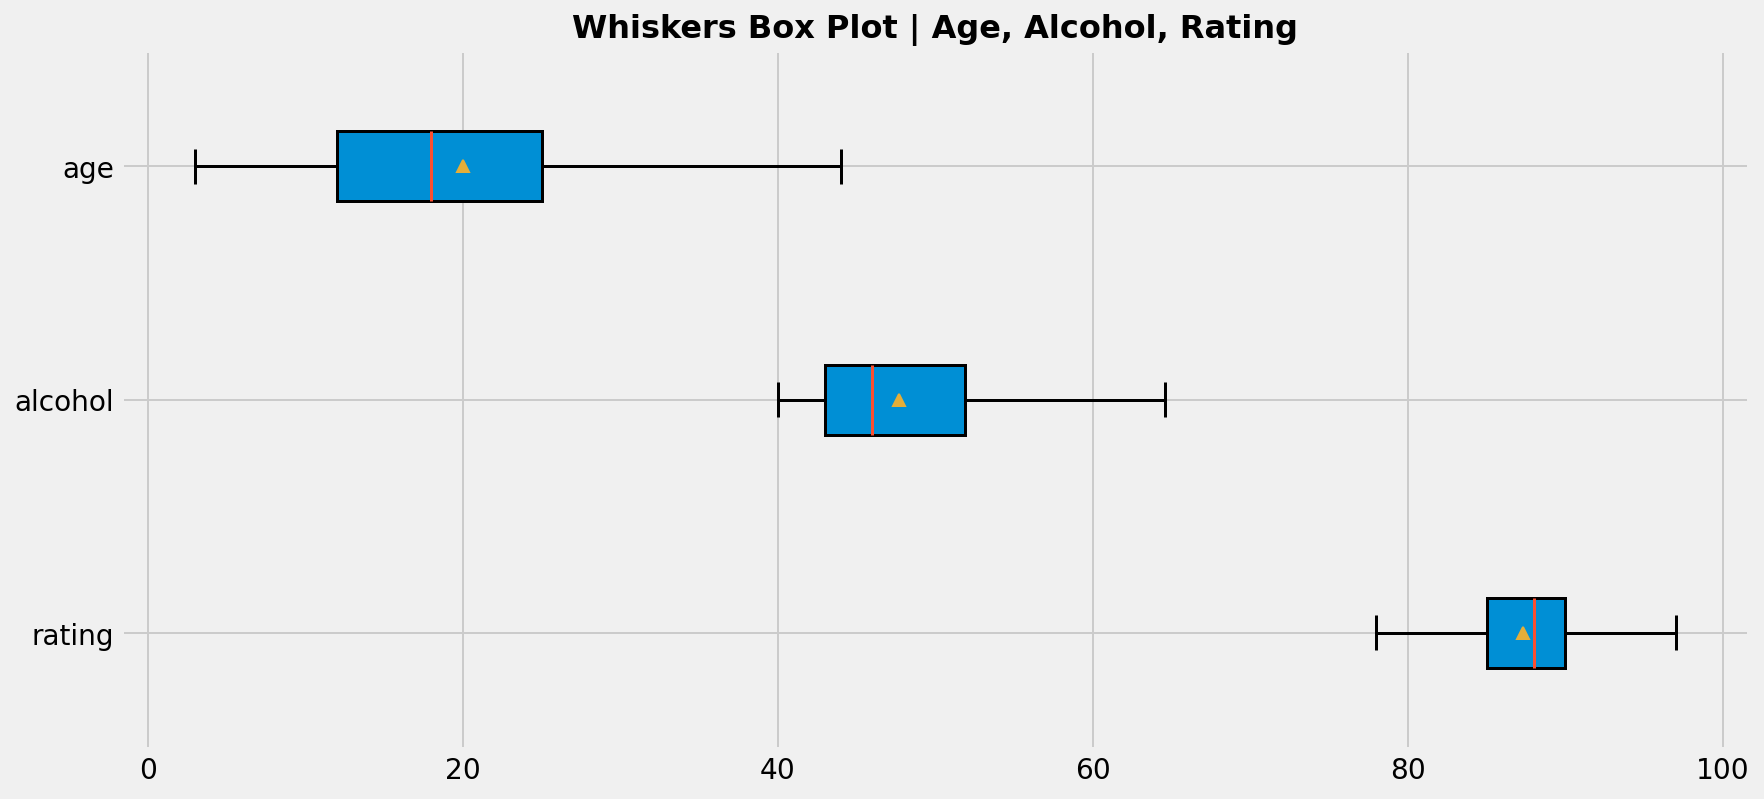

In [28]:
visualize_box_plot(df_num.iloc[:,:3], 'Whiskers Box Plot | Age, Alcohol, Rating')

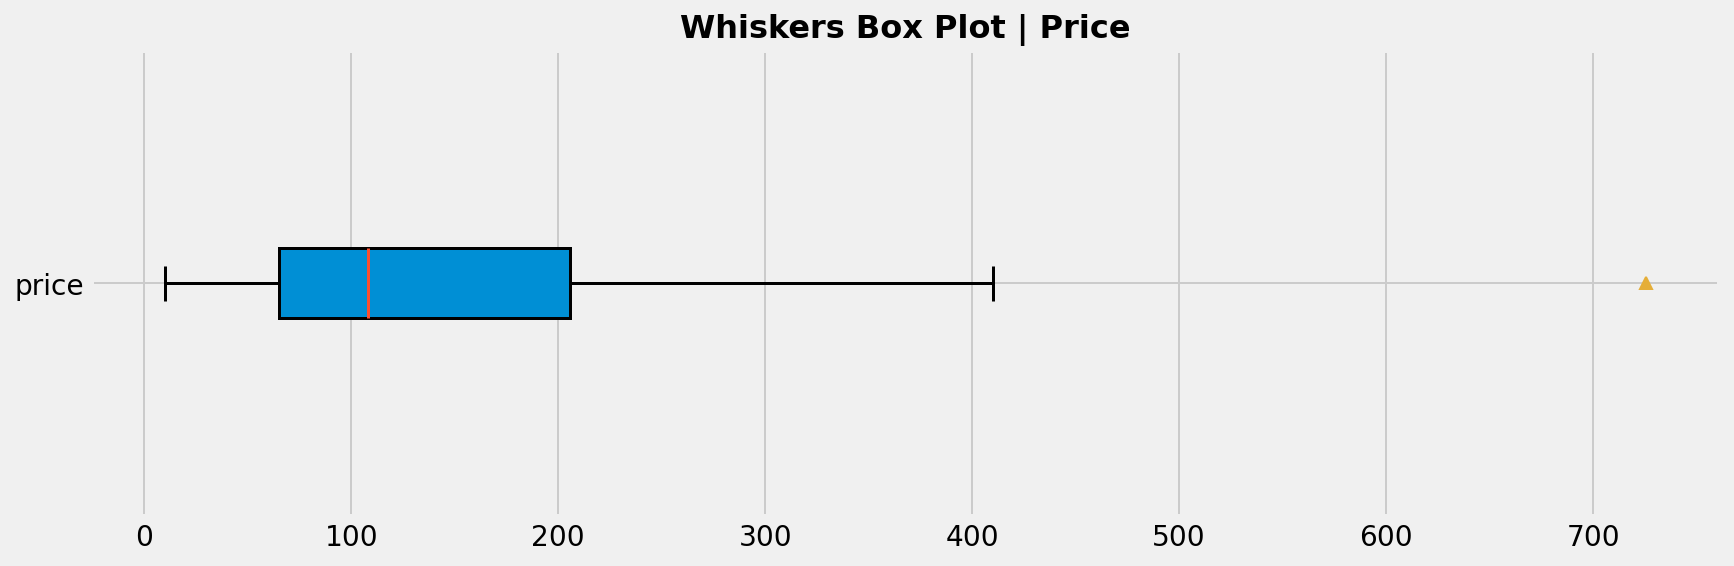

In [29]:
with plt.style.context('fivethirtyeight'):
    df_num.iloc[:,3].plot.box(vert = False, figsize = (13,4), showfliers = False, showmeans = True, 
                 patch_artist=True, boxprops=dict(linestyle='-', linewidth=1.5),
                 flierprops=dict(linestyle='-', linewidth=1.5),
                 medianprops=dict(linestyle='-', linewidth=1.5),
                 whiskerprops=dict(linestyle='-', linewidth=1.5),
                 capprops=dict(linestyle='-', linewidth=1.5))

    plt.title("Whiskers Box Plot | Price", fontsize=16, fontweight='heavy')
    plt.show()

* The `rating` variable begins from 70% (quite skewed, thus there are no bad whiskeys, as quoted!) and the Mean review is around 87%.
* As expected (for a whiskey), the `age` and the `alcohol` begin from 3 years old and 40%, respectively, with the former noting an average of 20 years old.
* Taking into account the `price` feature, the average (yellow ▲) Scotch goes for 700 US $, while the Median (red line) is at 108 $. This is a clear indication that the distribution is *right-skewed*. Yet, what is highlighted is the range from 10 to 157.000 $!

As per the Assumption #3 (see above), no Sales data are available and inevitably, we have to manipulate the existent features. We build-up to the following 'mechanism':
The Vendor is interested in increasing the profit margin, thus opening the [`price-cost`] gap. Besides being right-skewed, the `price` itself cannot be used as a decision factor for the Vendor, since selling extra expensive bottles, also means extra procurement cost`

**Finding #1: We should not follow the price as a decision factor. Eventually, we have to capture any interrelation among the features that may reveal which force drives the sales (and profit) upwards.**
## II. Deep insights

Apart from the obvious, inspecting the variables 'pairwisely', we may capture the useful relationships:

array([[<AxesSubplot:xlabel='rating', ylabel='rating'>,
        <AxesSubplot:xlabel='alcohol', ylabel='rating'>,
        <AxesSubplot:xlabel='age', ylabel='rating'>,
        <AxesSubplot:xlabel='price', ylabel='rating'>],
       [<AxesSubplot:xlabel='rating', ylabel='alcohol'>,
        <AxesSubplot:xlabel='alcohol', ylabel='alcohol'>,
        <AxesSubplot:xlabel='age', ylabel='alcohol'>,
        <AxesSubplot:xlabel='price', ylabel='alcohol'>],
       [<AxesSubplot:xlabel='rating', ylabel='age'>,
        <AxesSubplot:xlabel='alcohol', ylabel='age'>,
        <AxesSubplot:xlabel='age', ylabel='age'>,
        <AxesSubplot:xlabel='price', ylabel='age'>],
       [<AxesSubplot:xlabel='rating', ylabel='price'>,
        <AxesSubplot:xlabel='alcohol', ylabel='price'>,
        <AxesSubplot:xlabel='age', ylabel='price'>,
        <AxesSubplot:xlabel='price', ylabel='price'>]], dtype=object)

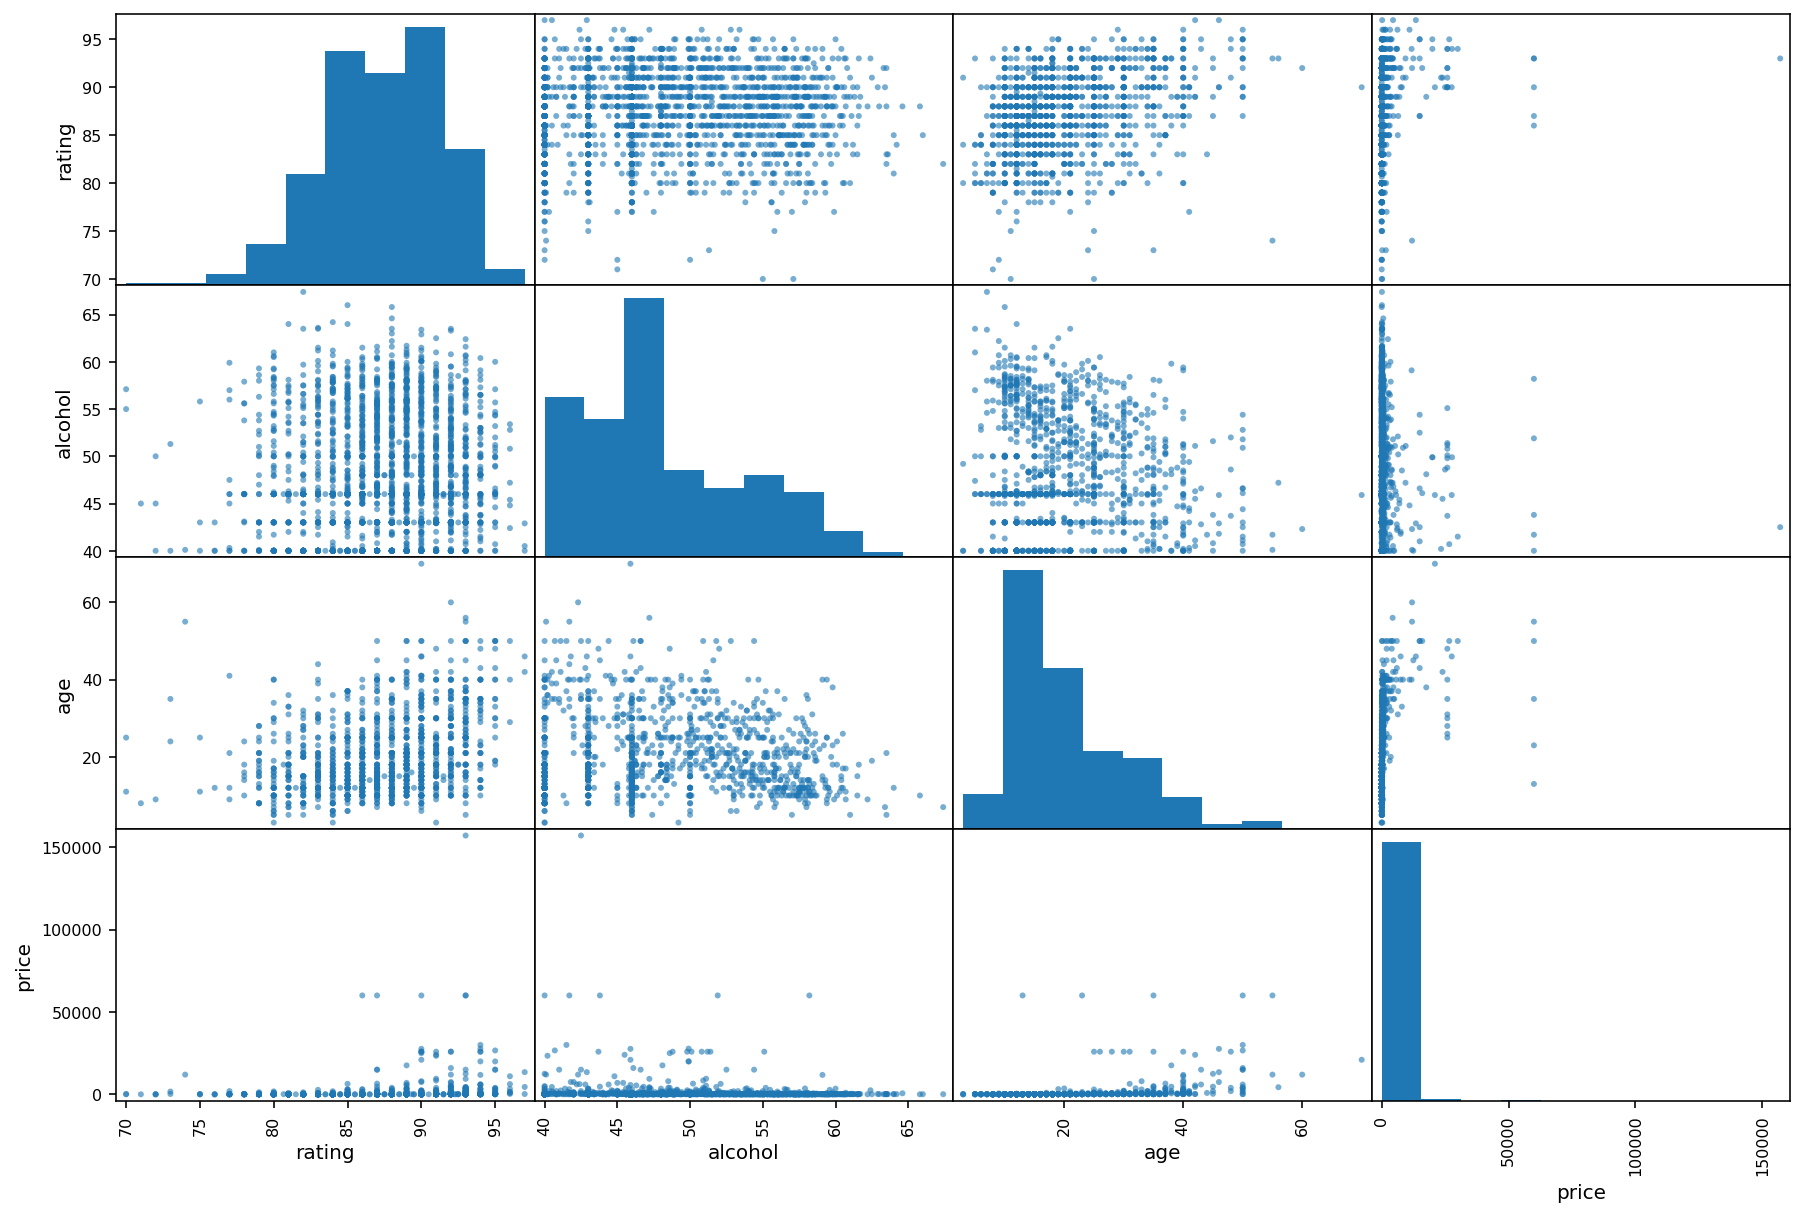

In [30]:
from pandas.plotting import scatter_matrix
scatter_matrix(df_num, figsize=(15, 10), alpha=0.6)

In [31]:
# Calculate the  the Pearson’s correlation coefficient between the numerical features
df_num.corr()

,rating,alcohol,age,price
rating,1.000000,0.070653,0.325555,0.129009
alcohol,0.070653,1.000000,-0.042081,-0.013003
age,0.325555,-0.042081,1.000000,0.334344
price,0.129009,-0.013003,0.334344,1.000000


Interpreting the matrix with the Pearson's correlation coefficients, the most profound findings we get are the following:
* The most exciting finding is that a good rating  to do not necessarily come with high a price (cor = 0.12). In other words, there is much potential to enjoy Scotch of high quality spending less dollars - a clear bargain.
* There is, also, a decent relationship between the age and rating (cor = 0,32).
* The highest interrelation (cor = 0,33) is noted between the price and age; the extra expensive bottles belong to the mature liquors. But, evidently, if the Vendor opt to acquire a firm which produces extra mature whiskies, they will conceivably result to sell extremely expensive liquors, biasing that way their variety distribution:

In [32]:
display(df_num[df_num['age'] > 30]['price'].sort_values(ascending=False).head(10))

186    60000.0
739    60000.0
182    60000.0
82     30000.0
699    27620.0
29     26650.0
102    25899.0
397    25899.0
103    25899.0
816    25899.0
Name: price, dtype: float64

So, apart from excluding price (Finding #1) we should also rule out the age and alcohol, too.

**Finding #2: Consequently, we should concentrate on the `rating` feature, which is expected to have a great effect on the Vendor's profit (more popular means higher sales).**
## III. Deeper insights

We will try to find a pattern that may enlight the Vendor on what bottles to promote mostly in order to get higher profit. In this context, we are going to analyse the 'kava' by the `category` attribute.

In [33]:
df.category.value_counts()

Single Malt Scotch            2108
Blended Scotch Whisky          276
Blended Malt Scotch Whisky     182
Name: category, dtype: int64

In [34]:
sngl_mlt = df[df['category'] == 'Single Malt Scotch'].copy()
blnd = df[df['category'] == 'Blended Scotch Whisky'].copy()
blnd_mlt = df[df['category'] == 'Blended Malt Scotch Whisky'].copy()

In [35]:
df.groupby('category').agg(np.mean)

,rating,alcohol,age,price
category,,,,
Blended Malt Scotch Whisky,88.114011,46.571429,18.148936,126.836538
Blended Scotch Whisky,87.885870,42.635145,20.107692,826.885870
Single Malt Scotch,87.157179,48.486654,20.095359,763.771505


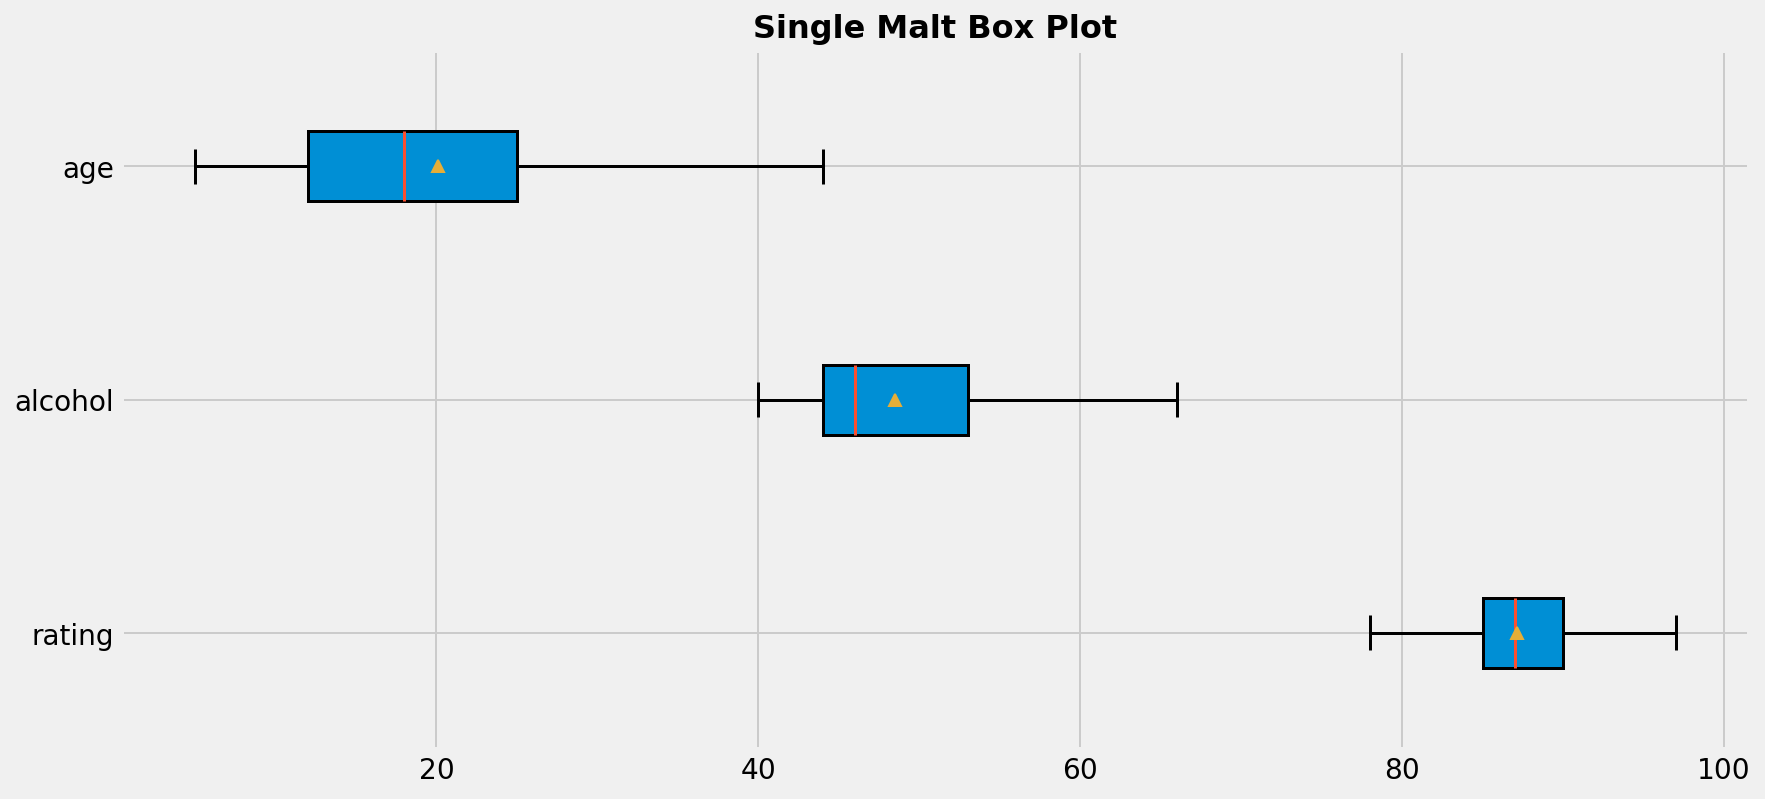

In [36]:
visualize_box_plot(sngl_mlt.iloc[:,2:5], 'Single Malt Box Plot')

In [37]:
sngl_mlt['price'].head()

0     4500.0
1    13500.0
3      750.0
4     1500.0
5     1500.0
Name: price, dtype: float64

In [38]:
# Visualizing box plots

def visualize_grouped_box_plots(df, cols, group, title):
    """
    Takes in a dataframe, the cols to be depicted, the one col to groupby
    the df and the title of the plot. It returns a Whiskers Box Plot.
    Parameters
    ---------
    df           : a dataframe object
             Represents the dataframe to be depicted
    cols         : a string
             Represents the columns to be depicted 
    group        : a string
             Represents the specific dataframe's column by which the subplots are grouped
    title        : a string
             Passes the title of the plot
    Returns
    -------
    plot : plot
             A Box plot
    """
    with plt.style.context('fivethirtyeight'):
        df.boxplot(column=cols, by=group, vert = False, figsize = (13,6), showfliers = False, showmeans = True, 
                 patch_artist=True, boxprops=dict(linestyle='-', linewidth=1.5),
                 flierprops=dict(linestyle='-', linewidth=1.5),
                 medianprops=dict(linestyle='-', linewidth=1.5),
                 whiskerprops=dict(linestyle='-', linewidth=1.5),
                 capprops=dict(linestyle='-', linewidth=1.5))
        plt.title(title, fontsize=16, fontweight='heavy')
        plt.show()

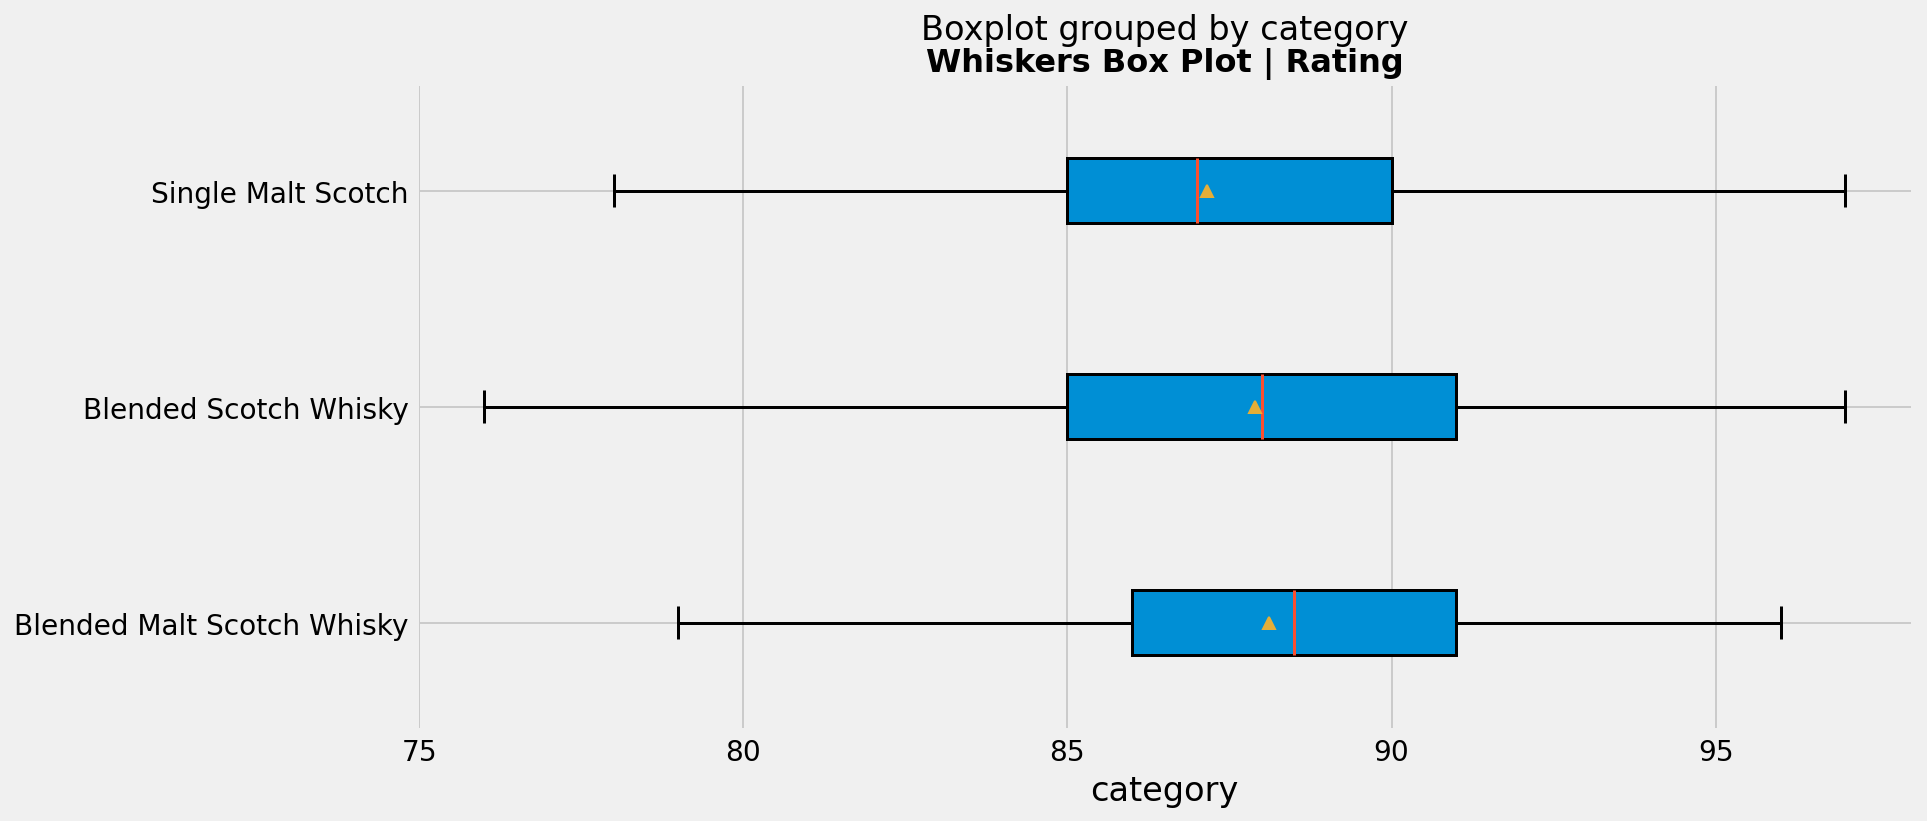

In [39]:
visualize_grouped_box_plots(df, 'rating', 'category', 'Whiskers Box Plot | Rating')

The Blended Malt takes the lead in `rating`, with the simple Blended coming next - the former's Mean is by 0,23% (88,11–87,88) higher. It is noteworthy,  that the Blended Malt's Median is quite above the 2nd quartile (Mean), hence more than 50% of the bottles are rated above the average (88%). This is a decent insight, we may provide the Vendor with…

**Finding #3: The Vendor may choose to boost the sales of the Blended Malts. That way, they may achieve bigger sales, due to the popularity of this whiskey type and as a result enjoy higher profits.**

⚠️ But, we still violate Condition #3 (preserve the whiskies variety) - a problem we haven't yet tackled properly. So, instead of recommending Blended (and only) bottles and to guarantee variety to the customers, we proceed to new, more comprehensive way of clustering.

## 3. Unsupervised Machine Learning ~ K-Means Clustering

## IV. Top Insights
We are going to groups similar rows in such a way, that look at the clusters, we will start to better understand the structure of the data. K-Means Clustering is a popular centroid-based clustering algorithm.

In [40]:
# Switch to a new dataframe, reduced to the rows with no nulls
df_no_nuls = df.dropna().copy()

In [41]:
df_no_nuls.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1355 entries, 0 to 2635
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         1355 non-null   object 
 1   category     1355 non-null   object 
 2   rating       1355 non-null   float64
 3   alcohol      1355 non-null   float64
 4   age          1355 non-null   float64
 5   price        1355 non-null   float64
 6   description  1355 non-null   object 
dtypes: float64(4), object(3)
memory usage: 84.7+ KB


In [42]:
# Subset to the numerical columns we are about to use on the ML algorithm 
data = df_no_nuls[['rating', 'alcohol', 'age']].copy()

In [43]:
max_clusters = 11
wcss = list()

for k in range(1, max_clusters):
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=1)
    kmeans.fit(data)
    wcss.append(kmeans.inertia_)

In [44]:
wcss

[195394.47397430072,
 107384.13547307356,
 77605.26630668229,
 61553.704534159675,
 53308.144627222755,
 47879.45887780391,
 43727.86462133834,
 40478.795074261565,
 37261.637468694054,
 34813.032648208]

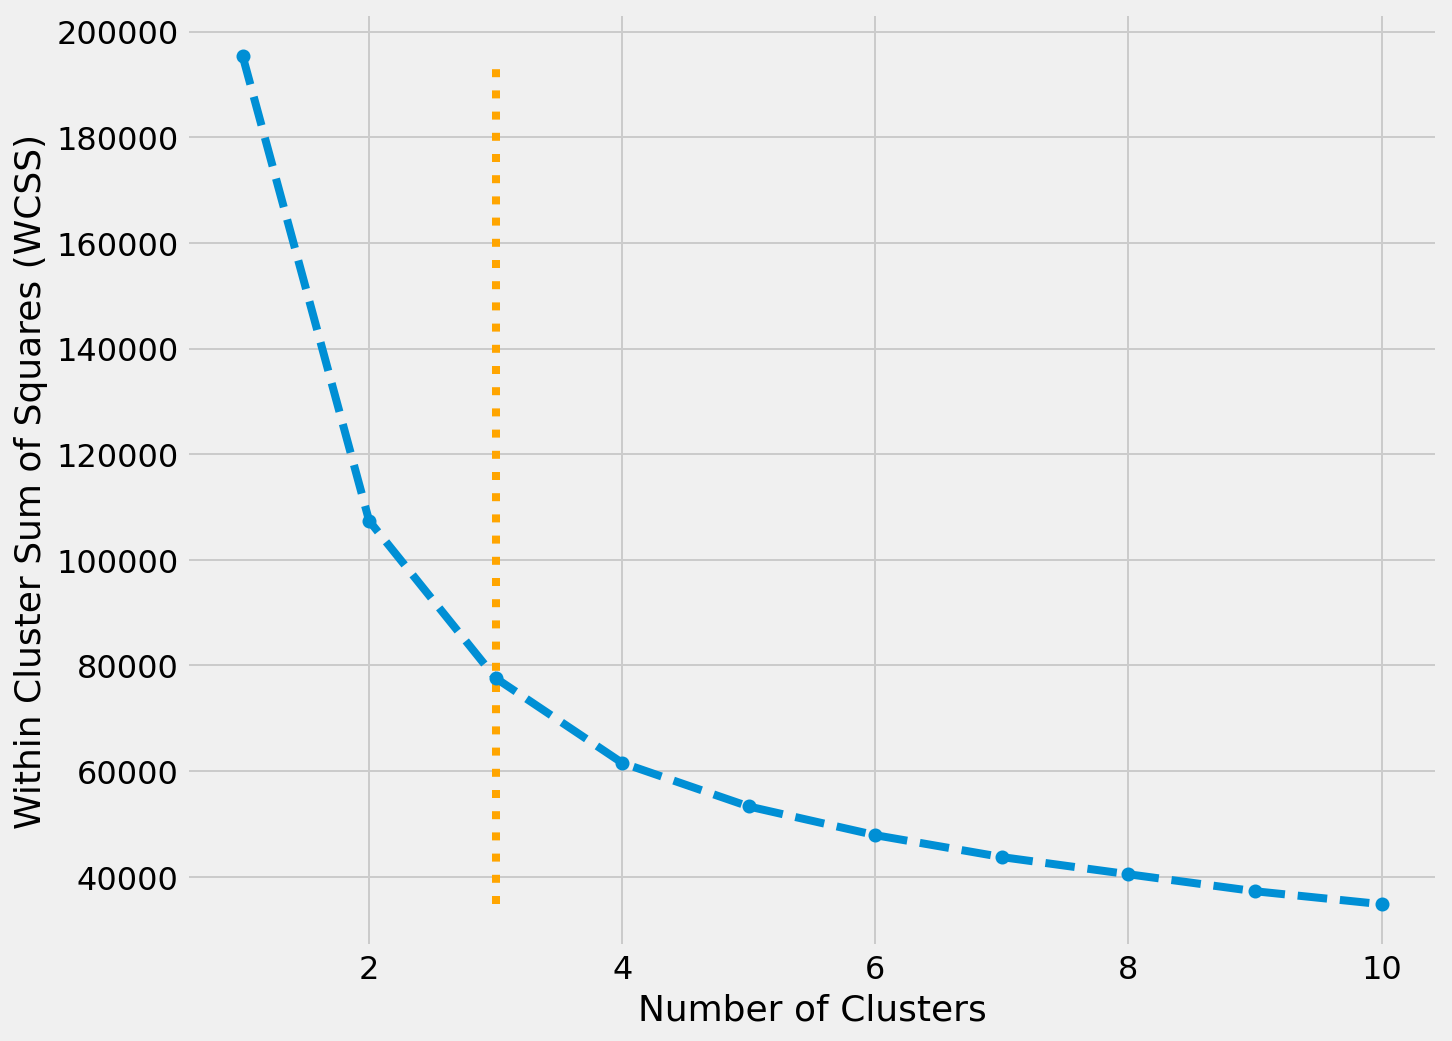

In [45]:
# Visualize the curve in order to locate the elbow
with plt.style.context('fivethirtyeight'):
    fig = plt.figure(figsize=(10,8))
    plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
    plt.vlines(KneeLocator([i for i in range(1, max_clusters)], wcss, curve='convex', direction='decreasing').knee, ymin=min(wcss), ymax=max(wcss), linestyles='dotted', color='orange')
    plt.xlabel('Number of Clusters', fontsize=18)
    plt.ylabel('Within Cluster Sum of Squares (WCSS)', fontsize=18)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.show()

In [46]:
# Locate the elbow
n_clusters = KneeLocator([i for i in range(1, max_clusters)], wcss, curve='convex', direction='decreasing').knee
print("Optimal # of clusters:", n_clusters)

Optimal # of clusters: 3


In [47]:
# Instantiate a KMeans model with 3 clusters, fit and predict cluster indices
kmeans = KMeans(n_clusters=3, init='k-means++', random_state=1)
kmeans.fit_predict(data)
df_no_nuls['cluster'] = kmeans.labels_
data['cluster'] = kmeans.labels_

The model showcased the following clusters and {num of bottles}, respectively: Cluster 0 {# 353}, Cluster 1{# 363} & Cluster 2{# 639}. Inspecting the pertinent Box Plots along with with those of Section 3, we deduce that:

In [48]:
df_no_nuls.cluster.value_counts()

2    639
1    363
0    353
Name: cluster, dtype: int64

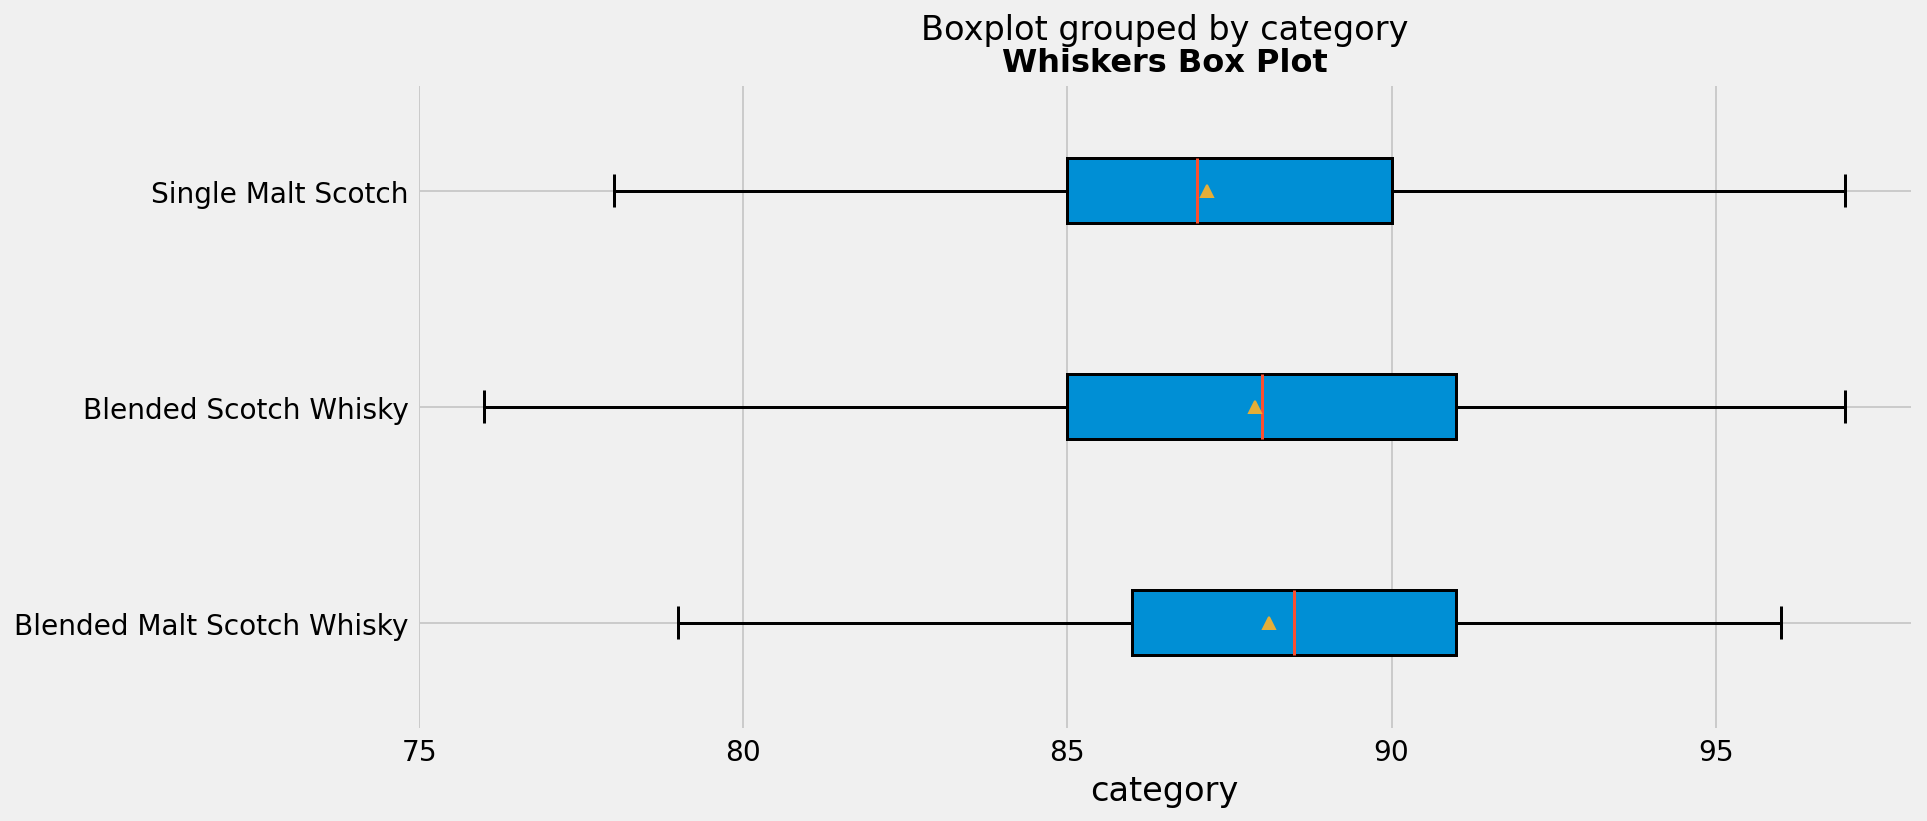

In [49]:
visualize_grouped_box_plots(df, 'rating', 'category', 'Whiskers Box Plot')

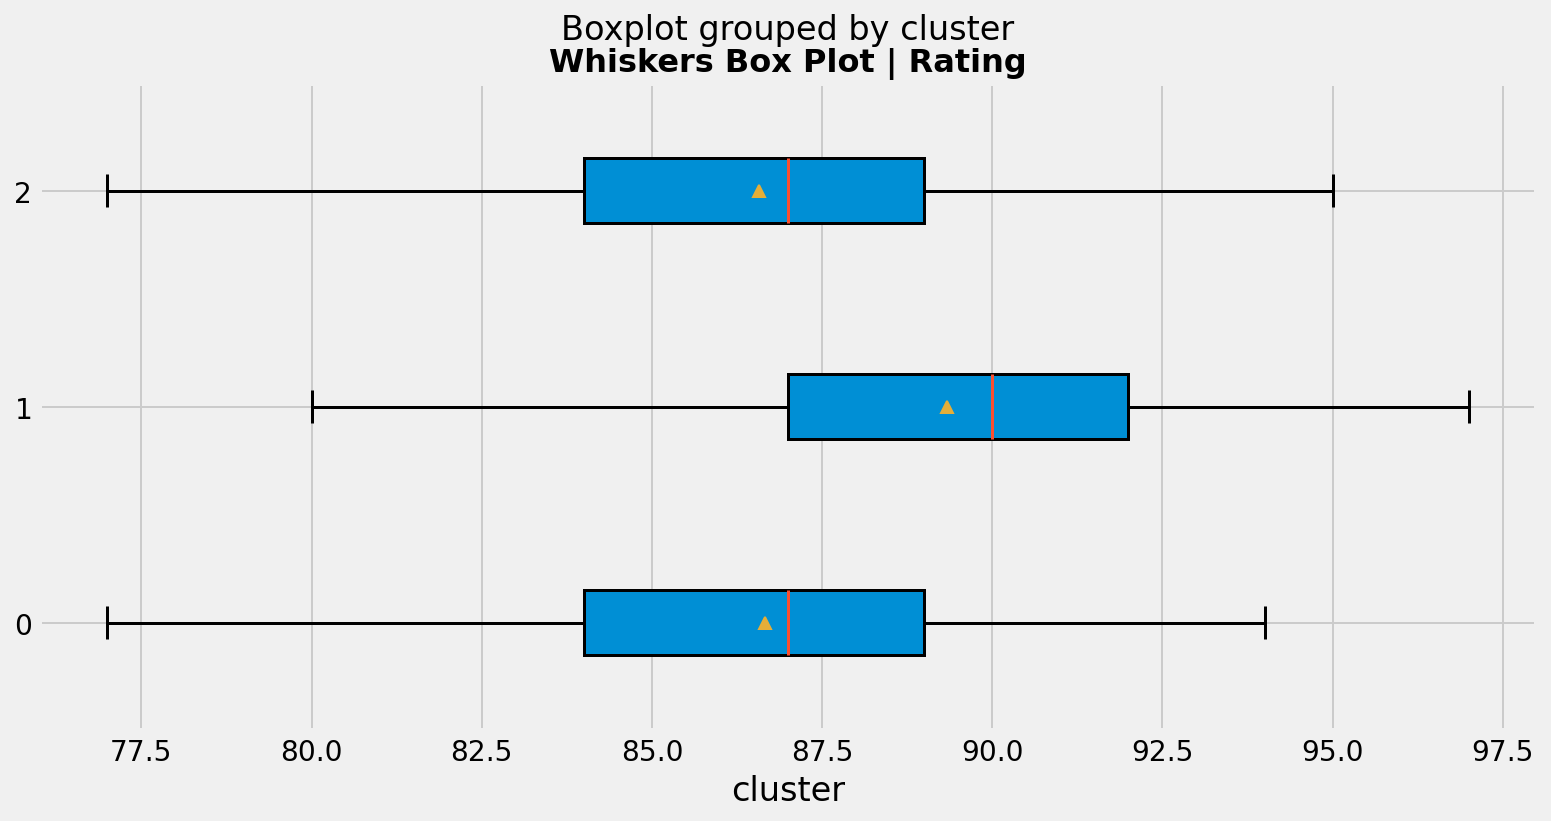

In [50]:
visualize_grouped_box_plots(df_no_nuls, 'rating', 'cluster', 'Whiskers Box Plot | Rating')

In [51]:
df_no_nuls['rating'].max()

97.0

✔️ Clustering reveals a clearer indication of what whiskey types foster the `rating` (and sales, as well). See how the new Clusters distinguish themselves, as compared to the categories of previous analysis.

✔️ Cluster #1 is way better when it comes to terms of `rating`. Not only the Mean gets ahead of the rest, but its Median is located to the rightmost, meaning that at least half of the cluster's bottles overtake even that remarkable value (89,33%).

✔️ At the same time, Cluster #1 includes Single Malt Scotch {#321}, Blended Scotch Whisky {#33} and Blended Malt Scotch Whisky {#9} - thus, variety achieved!

✔️ The analysis, hitherto, takes into account more features (`rating`, `alcohol`, `age`) than the previously attempted (`rating`), proving the point that clustering promotes a more comprehensive separation of data, deriving from signals of more components.

In [52]:
# Visualizing clusters

def visualize_clusters_3d(df, num_clusters):
    """
    Takes in a dataframe and the # of clusters
    applied on the K-Means algorithm,
    returns a 3D scatter plot labeled by the clusters
    Parameters
    ---------
    df           : a dataframe object
             Represents the dataframe the K-Means model is fitted with 
    num_clusters : number of clusters
             Passes the number of clusters produced by model
    Returns
    -------
    plot : plot
             A 3 dimensional scatter plot
    """
    with plt.style.context('fivethirtyeight'):
        fig = plt.figure(figsize=(10,10))
        ax = fig.add_subplot(111, projection='3d')
        colors = ['r', 'g', 'b']

        for n in range(num_clusters):
            clustered_df = df[df['cluster'] == n]
            ax.scatter(clustered_df['age'], clustered_df['rating'], clustered_df['alcohol'], label=n, c=colors[n-1])
            ax.set_xlabel('Age',fontsize=13)
            ax.set_ylabel('Rating', fontsize=13)
            ax.set_zlabel('Alcohol', fontsize=13)
            ax.tick_params(axis="x", labelsize=10)
            ax.tick_params(axis="y", labelsize=10)
            ax.tick_params(axis="z", labelsize=10)
            ax.legend()
        plt.show()

Bringing all of them to the same space, we can visualise a 3D Scatter Plot. Actually, we are marginally able to do so, because for >3 variables a Dimensionality Reduction Process (like PCA etc) is necessary.

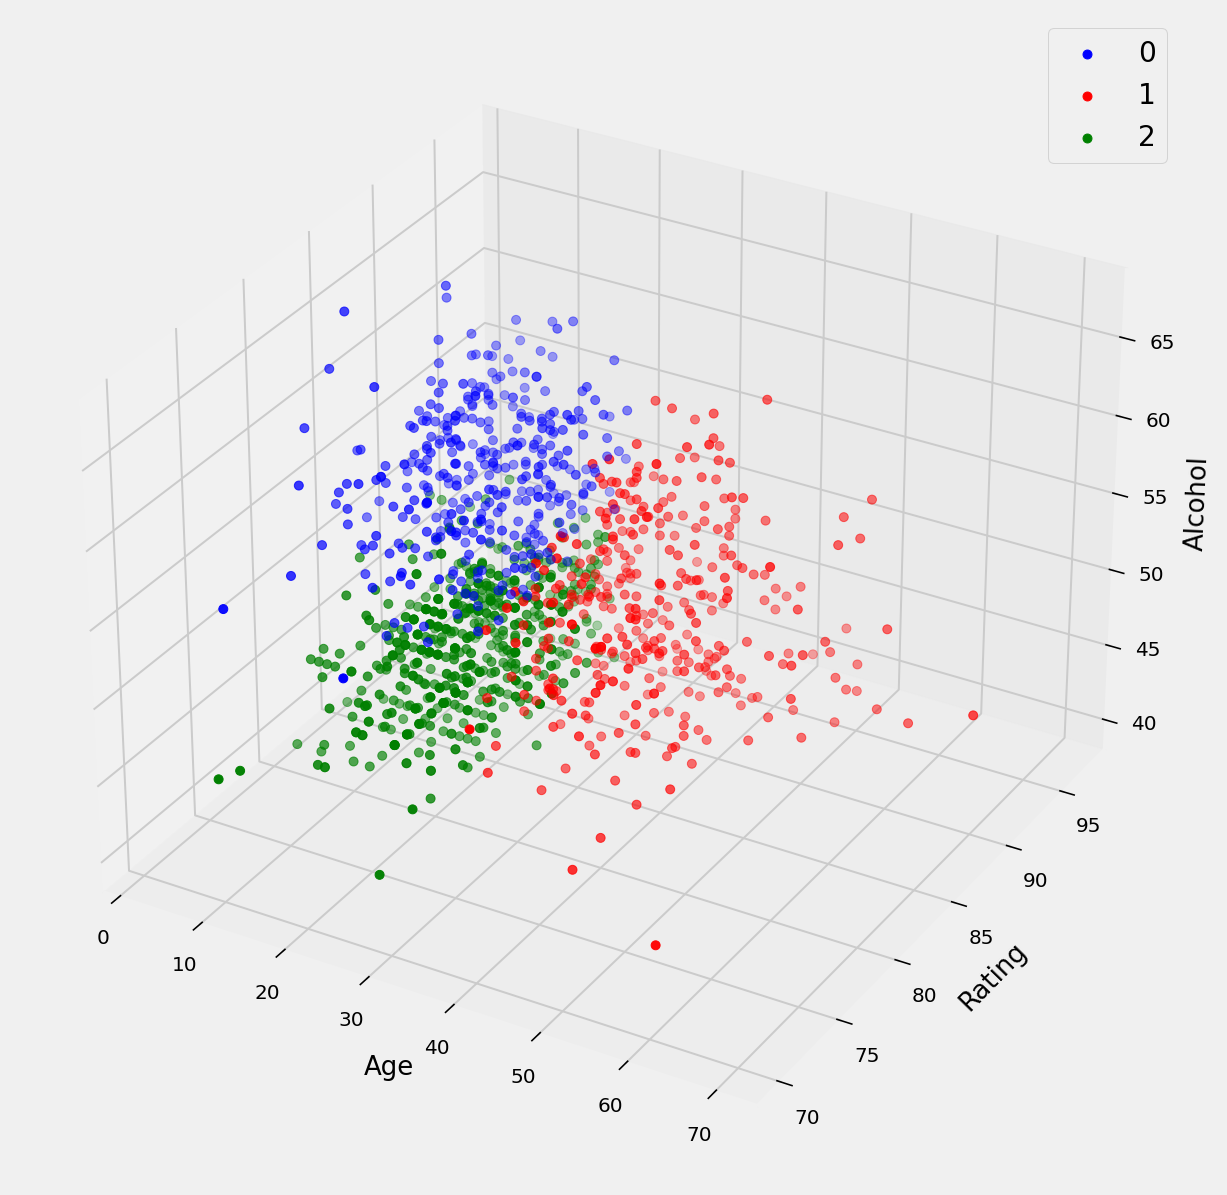

In [53]:
visualize_clusters_3d(df_no_nuls, 3)

In [54]:
df_no_nuls[df_no_nuls['cluster'] == 2].value_counts('category')

category
Single Malt Scotch            515
Blended Scotch Whisky          96
Blended Malt Scotch Whisky     28
dtype: int64

In [55]:
df_no_nuls[df_no_nuls['cluster'] == 1].value_counts('category')

category
Single Malt Scotch            321
Blended Scotch Whisky          33
Blended Malt Scotch Whisky      9
dtype: int64

In [56]:
df_no_nuls.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1355 entries, 0 to 2635
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         1355 non-null   object 
 1   category     1355 non-null   object 
 2   rating       1355 non-null   float64
 3   alcohol      1355 non-null   float64
 4   age          1355 non-null   float64
 5   price        1355 non-null   float64
 6   description  1355 non-null   object 
 7   cluster      1355 non-null   int32  
dtypes: float64(4), int32(1), object(3)
memory usage: 90.0+ KB


In [57]:
# Normalize the feature columns
def normalize_df(df_feat, df_no_feat):
    """
    Takes in 2 dataframes, normalizes the 1st,
    concatenates with the 2nd and returns the
    total.
    Parameters
    ---------
    df_feat    : a dataframe object
             Represents the dataframe to be normalized 
    df_no_feat : a dataframe object
             Represents the dataframe not normalized
    Returns
    -------
    pd.concat  : a dataframe object
            Represents the concatenated dataframe
    """
    norm = MinMaxScaler().fit_transform(df_feat)
    scaled = pd.DataFrame(norm, index=df_feat.index, columns = df_feat.columns)
    return pd.concat([df_no_feat, scaled], axis=1)

In [58]:
df_feat = df_no_nuls[['rating', 'alcohol', 'age', 'price']]
df_no_feat = df_no_nuls.drop(['rating', 'alcohol', 'age', 'price'], axis=1)

In [59]:
df_norm = normalize_df(df_feat, df_no_feat)

In [80]:
fig = go.FigureWidget()

angles = list(df_norm.columns[4:])
angles.append(angles[0])

layoutdict = dict(
            radialaxis=dict(
            visible=True,
            range=[0, 1]
            ))

for i in range(3):
    subset = df_norm[df_norm['cluster'] == i]
    data = [np.mean(subset[col]) for col in subset.columns[4:]]
    data.append(data[0])
    fig.add_trace(go.Scatterpolar(
        r=data,
        theta=angles,
        fill='toself',
        name="Cluster " + str(i)
))
    
fig.update_layout(
        polar=layoutdict,
        showlegend=True,autosize=False,
        width=1000,
        height=800, font=dict(
        family="Verdana",
        size=20)
        )
fig.show()

It is quite prominent that Cluster #1 (red) 'occupies' the higher area of y-axis (`rating`). Additionally, should we normalise the data, we can render a Radar Plot. This one can further assist the results interpretation, by illustrating how better the red polygon 'concers' all the features.
## 4. Supervised Learning ~ Logistic Regression

### Predictions
We are faced with a problem where there are 3 categories (or else classes). Among the available multiclassification techniques, we opt for the he one-versus-all method (transformation to binary technique). It is a technique where we choose a single category as the Positive case and group the rest of the categories as the False case. Each of these models (which is created each time) is a binary classification model that will return a probability between 0 and 1. When we apply this model on new data, a probability value will be returned from each model for each observation and we choose the label corresponding to the model that predicted the highest probability.

In [61]:
# Switch to a copy of the labeled dataframe
df_no_nuls_2 = df_no_nuls.copy()

In [62]:
df_no_nuls_2.shape

(1355, 8)

In [63]:
# Randomise the df
shuffled_rows = np.random.permutation(df_no_nuls_2.index)
df_no_nuls_2 = df_no_nuls_2.loc[shuffled_rows]

In [64]:
# Split to train and test datasets
train = df_no_nuls_2.iloc[:int(df_no_nuls_2.shape[0]*0.8)].copy()
test = df_no_nuls_2.iloc[int(df_no_nuls_2.shape[0]*0.8):].copy().reset_index()

In [65]:
# Subset to the numerical columns we are about to use on the ML algorithm 
train_data = train[['rating', 'alcohol', 'age']].copy()
test_data = test[['rating', 'alcohol', 'age']].copy()

In [66]:
unique_clusters = train['cluster'].unique()
unique_clusters.sort()

models = {}

In [67]:
for cluster in unique_clusters:
    X = train[['rating', 'alcohol', 'age']].copy()
    y = train['cluster'] == cluster
    
    model = LogisticRegression()
    model.fit(X, y)
    models[cluster] = model

In [68]:
testing_probs = pd.DataFrame(columns=unique_clusters)

In [69]:
for cluster in unique_clusters:
    X_test = test[['rating', 'alcohol', 'age']].copy()
    testing_probs[cluster] = models[cluster].predict_proba(X_test)[:,1]

In [70]:
X_test

,rating,alcohol,age
0,85.0,54.2,16.0
1,89.0,48.1,30.0
2,95.0,40.0,18.0
3,86.0,51.5,20.0
4,90.0,40.0,15.0
...,...,...,...
266,89.0,54.1,14.0
267,84.0,43.0,21.0
268,84.0,40.0,10.0
269,87.0,46.0,16.0


In [71]:
test['pred_cluster'] = testing_probs.idxmax(axis=1)

In [72]:
(test['cluster'] == test['pred_cluster']).sum()

271

In [73]:
test.shape

(271, 10)

In [74]:
(test['cluster'] == test['pred_cluster']).sum() / test.shape[0]

1.0

An accuracy of 98.9% was achieved, meaning that almost 98 out of 100 new liquor entries may be succesfully categorized to one of the 3 clusters we developed. Of course, the model has to be evaluated on new data and this is only part of the testing procedure...
## Conclusion
Eventually, we reached our destination; from the apparent to the well-rounded insights of what 'type' of whiskies may foster the Vendor's entrepreneurship.

Starting from a web-scrapper, we formed an adequate dataset, then analysed it with plain EDA. Next, we applied an Unsupervised ML model (K-Means) to reveal insightful patterns, which helped us better identify what it really takes to boost the Whiskey Sales, artfully. Finally, we fitted a Logistic Regression model on the labelled dataset, predicting with high accuracy in which Cluster a new bottle may register.